# Housing Prices Project (module 70)

## about Housing
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

TotalBsmtSF: Total square feet of basement area

BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Fireplaces: Number of fireplaces

PoolArea: Pool area in square feet

GarageCars: Size of garage in car capacity

WoodDeckSF: Wood deck area in square feet

ScreenPorch: Screen porch area in square feet

**rem:**
Unit of measurement is feet


# Imports and Settings

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# import data
data = pd.read_table("data/housing_iteration_0_2_classification.csv", sep=",")

# Preprocessing

## Data Splitting (X & y, train & test)

In [3]:
# delete data with NaNs in "intended y column"
data.dropna(subset=["Expensive"], inplace=True)

# define y (and X)
y = data.pop("Expensive")
X = data

# only numerical values
X = X.select_dtypes(include="number")

# ---> INPUTS  <------------------------------------------------------------< INPUTS
seed = 123
split = 0.2

# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)

## Data Cleaning (X_train)

In [4]:
# check for duplicates
duplicates = X_train.duplicated()
duplicated_rows = X_train[duplicates]
duplicated_rows

# X_train.drop_duplicates(inplace=True)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch
1090,8544,60.0,0,2,0,0,2,0,0
690,4426,NaN,848,1,1,0,2,149,0
1412,7200,60.0,0,2,0,0,2,0,0
430,1680,21.0,483,2,0,0,1,0,0
1088,2522,24.0,970,3,0,0,2,0,0
593,4435,NaN,848,1,0,0,2,140,0
193,2522,24.0,970,3,0,0,2,0,0
837,1680,21.0,483,2,0,0,1,0,0


In [5]:
# check for NaNs
X_train.isna().sum()
# --> SimpleImputer()

LotArea           0
LotFrontage     189
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
dtype: int64

# Modelling Decision Tree

## Pipeline

In [6]:
# 1. initialize transformers and model
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
model = DecisionTreeClassifier(max_depth=6)

In [7]:
# 2. Create and fit pipeline
pipe = make_pipeline(imputer, scaler, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])

## Cross Validation

In [8]:
# 3. create and fit Cross Validation  ---> INPUTS <-------------------------------------------< INPUTS
param_grid = {
    'simpleimputer__strategy':['mean', 'median'],
    'standardscaler__with_mean':[True,False],
    'standardscaler__with_std':[True,False],
    'decisiontreeclassifier__max_depth': range(3, 12),
    'decisiontreeclassifier__min_samples_leaf': range(5, 15),
    'decisiontreeclassifier__min_samples_split': range(10, 50, 5),
    'decisiontreeclassifier__criterion':['gini', 'entropy']
    }
CV = GridSearchCV(pipe, param_grid, cv=10, refit=True, scoring='accuracy', verbose=1)

CV.fit(X_train, y_train)

Fitting 10 folds for each of 11520 candidates, totalling 115200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(max_depth=6))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(3, 12),
                         'decisiontreeclassifier__min_samples_leaf': range(5, 15),
                         'decisiontreeclassifier__min_samples_split': range(10, 50, 5),
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [9]:
CV.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 6,
 'decisiontreeclassifier__min_samples_split': 10,
 'simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}

In [10]:
# the mean cross-validated score of the best estimator
CV.best_score_

0.9263778367226644

# Evaluation

## Accuracy (test data)

In [11]:
# train-accuracy
y_train_pred = CV.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

In [12]:
# test-accuracy
y_test_pred = CV.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

In [13]:
Delta = train_acc - test_acc
print(Delta, train_acc, test_acc)

0.006849315068493178 0.9383561643835616 0.9315068493150684


## Plotting Decision Tree

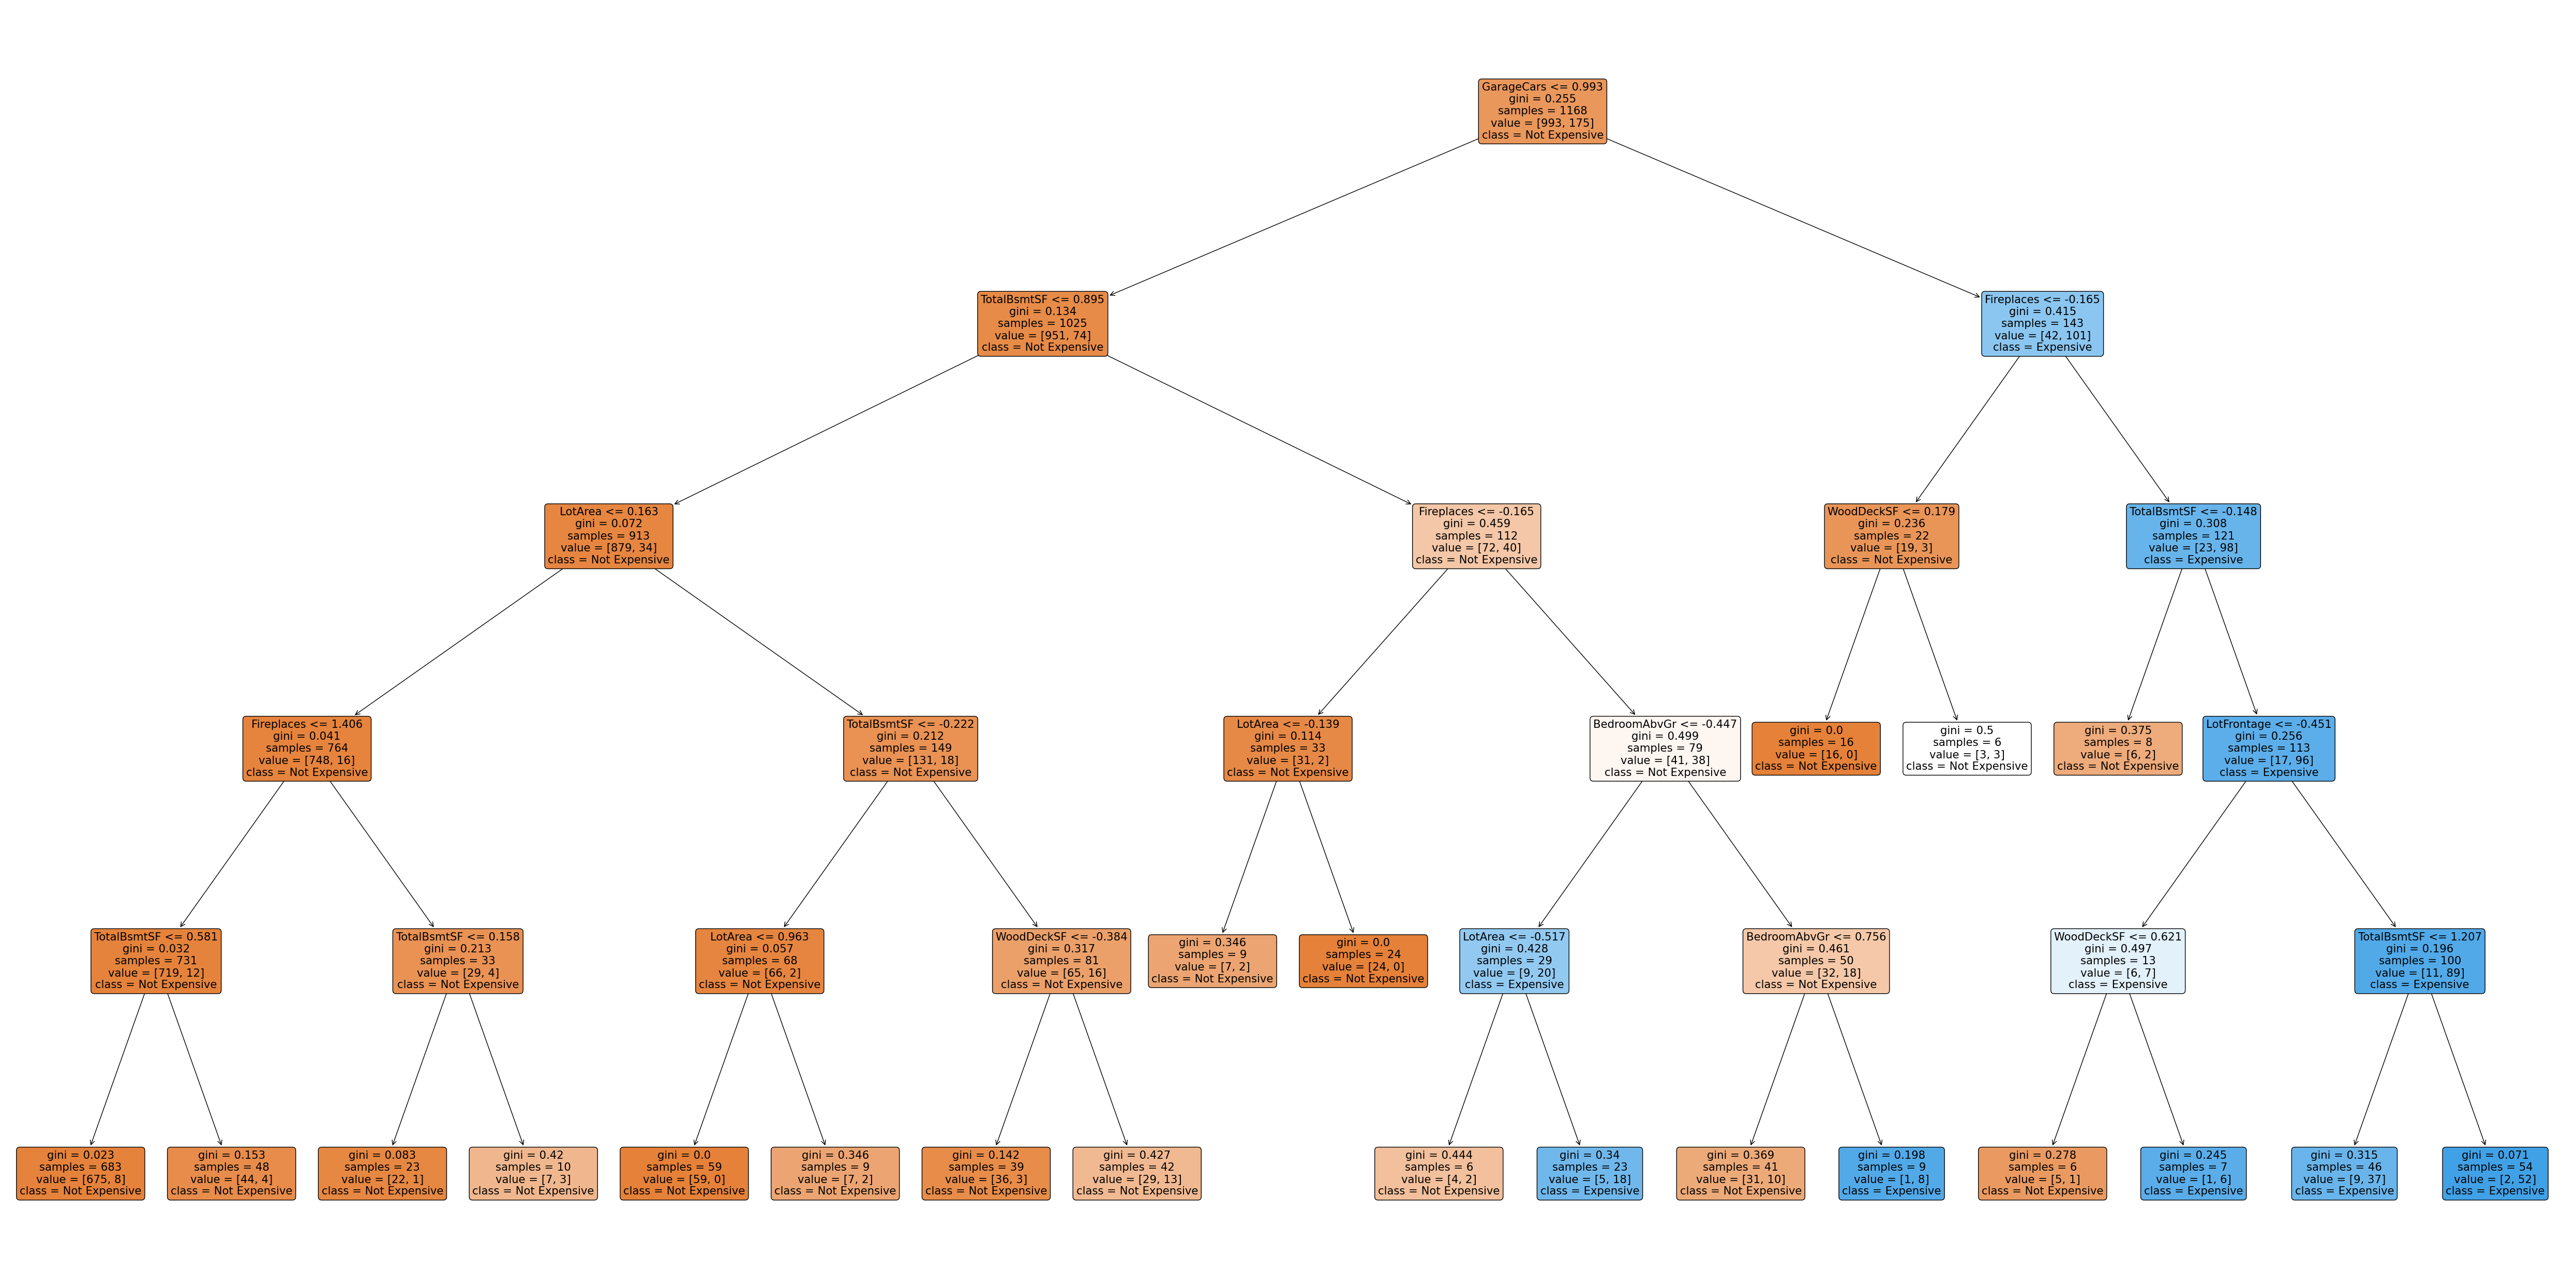

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(64, 32))

plot_tree(
     CV.best_estimator_['decisiontreeclassifier'],
     filled=True,
     rounded=True,
     class_names=['Not Expensive','Expensive'],
     feature_names=X_train.columns
     );